In [19]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pylab as plt

# import custom classes
from core.database import *
from core.forecast import *


# define db to pull historical data
db = Database(name='bdf')

# select commodity
commodity = 'gold'

# get historical data
data = db.get_commodity(commodity)
data.set_index('date', inplace=True)

# instantiate an object of Forecast class choosing Recurring Neural Network model
forecast = Forecast(data['price'], method='rnn')

# set parameters
forecast.rnn(learning_rate=0.001, hidden=200, horizon=1)

# fit model
forecast.fit()

# predict 
predicted = forecast.predict()

predicted


0 	MSE:  52444550.0
100 	MSE:  1065263.1
200 	MSE:  3143.9382
300 	MSE:  2041.2175
400 	MSE:  1640.8052
500 	MSE:  1514.754
600 	MSE:  1375.5837
700 	MSE:  1299.4554
800 	MSE:  1265.6078
900 	MSE:  1244.6447


[1346.796, 1360.417, 1364.6707, 1341.4298, 1338.0743]

Text(0.5,0,'Periods')

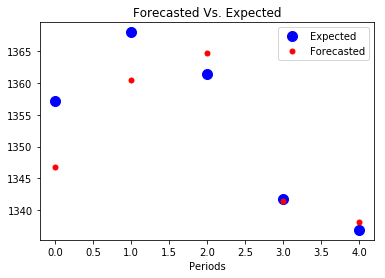

In [20]:
"""
    Plot:
        - scatterplot of observed and predicted values
"""

plt.plot(pd.Series(np.ravel(forecast.Y_test)), 'bo', markersize=10, label='Expected')
plt.plot(pd.Series(np.ravel(predicted)), 'r.', markersize=10, label='Forecasted')
plt.legend(loc='best')

plt.title('Forecasted Vs. Expected')
plt.xlabel('Periods')
